In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import decomposition

import tensorflow as tf
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.0.0


## Data exploration and tokenization

In [3]:
#data_dir = "/home/stavros/DATA"
data_dir = "D:/"
data = pd.read_csv("{}/AirlineSentiment/Tweets.csv".format(data_dir))

In [4]:
print(data.shape)
print(data.columns)

(14640, 15)
Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


In [5]:
print(data.airline_sentiment.value_counts())
print(data.airline_sentiment.value_counts().sum())

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
14640


In [6]:
print(data.negativereason.value_counts())
print(data.negativereason.value_counts().sum())

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64
9178


Keep negative reviews only

In [7]:
neg_data = data[data.airline_sentiment == "negative"]
print(neg_data.shape)

(9178, 15)


In [12]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000, oov_token="<UNK>")
tokenizer.fit_on_texts(neg_data.text)

In [13]:
num_words = tokenizer.num_words + 1
print(num_words)
neg_data["tokenized_text"] = [tokenizer.texts_to_sequences([s])[0] for s in neg_data.text]

20001


C:\Users\SU\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Mean train length: 19.96448027892787
Train length STD: 5.960486039738018


Text(0.5, 0, 'Lengths')

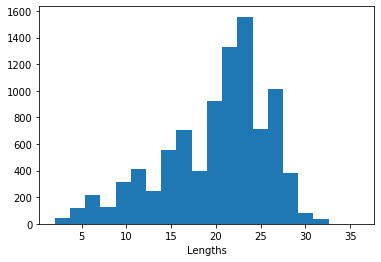

In [14]:
lengths = list(map(len, neg_data.tokenized_text))
plt.hist(lengths, bins=20)
print("Mean train length: {}".format(np.mean(lengths)))
print("Train length STD: {}".format(np.std(lengths)))
plt.xlabel("Lengths")

## Unigram model

Note that in order to use this, `neg_data` DataFrame should already be created and contain a `tokenized_text` column with the tokenized tweets. Use the above cells to create these. 

In [15]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D

In [16]:
#ngram_range = 1
max_features = num_words
maxlen = 30
embedding_dims = 50
batch_size = 32
epochs = 5

In [17]:
def create_one_hot_labels(data: pd.DataFrame):
    classes = list(data.negativereason.unique())
    y = np.zeros((len(data), len(classes)))
    for i, c in enumerate(classes):
        ind = np.where(data.negativereason == c)[0]
        y[ind, i] = 1
    return y, classes

In [18]:
x_train = sequence.pad_sequences(neg_data.tokenized_text, maxlen=maxlen)
y_train, classes = create_one_hot_labels(neg_data)
print(x_train.shape, y_train.shape)
print(classes)

(9178, 30) (9178, 10)
['Bad Flight', "Can't Tell", 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines']


In [19]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(len(classes), activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 50)            1000050   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 1,000,560
Trainable params: 1,000,560
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50)

Train on 9178 samples
Epoch 1/50
9178/9178 [==============================] - 4s 426us/sample - loss: 0.4225 - accuracy: 0.8957
Epoch 2/50
9178/9178 [==============================] - 3s 362us/sample - loss: 0.2859 - accuracy: 0.9000
Epoch 3/50
9178/9178 [==============================] - 3s 364us/sample - loss: 0.2771 - accuracy: 0.9000
Epoch 4/50
9178/9178 [==============================] - 3s 363us/sample - loss: 0.2655 - accuracy: 0.9011
Epoch 5/50
9178/9178 [==============================] - 3s 367us/sample - loss: 0.2498 - accuracy: 0.9076
Epoch 6/50
9178/9178 [==============================] - 3s 367us/sample - loss: 0.2328 - accuracy: 0.9151
Epoch 7/50
9178/9178 [==============================] - 3s 370us/sample - loss: 0.2171 - accuracy: 0.9222
Epoch 8/50
9178/9178 [==============================] - 3s 368us/sample - loss: 0.2034 - accuracy: 0.9268
Epoch 9/50
9178/9178 [==============================] - 3s 368us/sample - loss: 0.1913 - accuracy: 0.9307
Epoch 10/50
9178/9178 [=

In [24]:
train_pred = model.predict(x_train)
print((train_pred.argmax(axis=1) == y_train.argmax(axis=1)).mean())

0.971235563303552


#### PCA representation of final dense layer (before `sigmoid`)

In [25]:
from tensorflow.keras import models
nodense_model = models.Model(inputs=model.input, outputs=model.layers[1].output)
nodense_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 50)            1000050   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
Total params: 1,000,050
Trainable params: 1,000,050
Non-trainable params: 0
_________________________________________________________________


In [26]:
embedded_reviews = nodense_model.predict(x_train)

pca = decomposition.PCA(n_components=10)
embeddings_2d = pca.fit_transform(embedded_reviews)
print(pca.explained_variance_)

[0.10351163 0.0881405  0.07235274 0.06207274 0.04162669 0.035131
 0.02885718 0.0235249  0.01899991 0.00752285]


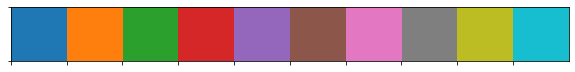

In [27]:
import seaborn as sns

cp = sns.color_palette(n_colors=len(classes))

sns.palplot(cp)
plt.show()

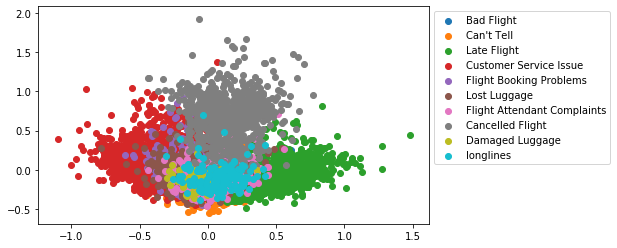

In [28]:
plt.figure(figsize=(7, 4))
y_train_flat = y_train.argmax(axis=1)
for i, c in enumerate(classes):
    ind = np.where(y_train_flat == i)[0]
    plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color=cp[i], label=c)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

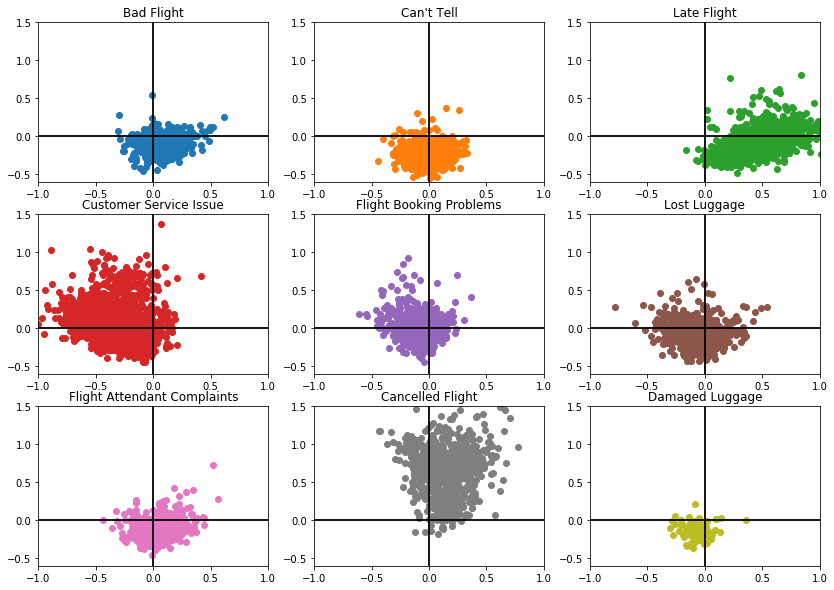

In [29]:
plt.figure(figsize=(14, 10))
y_train_flat = y_train.argmax(axis=1)
for i, c in enumerate(classes[:-1]):
    plt.subplot(331 + i)
    plt.title(c)
    ind = np.where(y_train_flat == i)[0]
    plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color=cp[i], label=c)
    plt.xlim([-1, 1])
    plt.ylim([-0.6, 1.5])
    plt.axvline(x=0, color="black", linewidth=1.8)
    plt.axhline(y=0, color="black", linewidth=1.8)
plt.show()

## Bigram model

Note that in order to use this, `neg_data` DataFrame should already be created and contain a `tokenized_text` column with the tokenized tweets. Use the above cells to create these. 

In [30]:
def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [32]:
# Set parameters:
ngram_range = 2
max_features = num_words

x_train = neg_data.tokenized_text
if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    #x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    #print('Average test sequence length: {}'.format(
    #    np.mean(list(map(len, x_test)), dtype=int)))

Adding 2-gram features
Average train sequence length: 38


In [34]:
print('Max train sequence length: {}'.format(np.max(list(map(len, x_train)))))

Max train sequence length: 71


In [39]:
maxlen = 70
batch_size = 32
embedding_dims = 60
epochs = 5

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
print('x_train shape:', x_train.shape)

y_train, classes = create_one_hot_labels(neg_data)
print(y_train.shape)
print(classes)

Pad sequences (samples x time)
x_train shape: (9178, 70)
(9178, 10)
['Bad Flight', "Can't Tell", 'Late Flight', 'Customer Service Issue', 'Flight Booking Problems', 'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight', 'Damaged Luggage', 'longlines']


In [40]:
model = Sequential()
model.add(Embedding(max_features, embedding_dims,
                    input_length=maxlen))
model.add(GlobalAveragePooling1D())
model.add(Dense(len(classes), activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 60)            5810280   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                610       
Total params: 5,810,890
Trainable params: 5,810,890
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=50)

Train on 9178 samples
Epoch 1/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.4300 - accuracy: 0.8913
Epoch 2/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2874 - accuracy: 0.9000
Epoch 3/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2775 - accuracy: 0.9000
Epoch 4/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2645 - accuracy: 0.9015
Epoch 5/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2464 - accuracy: 0.9080
Epoch 6/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2250 - accuracy: 0.9159
Epoch 7/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.2033 - accuracy: 0.9259
Epoch 8/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.1828 - accuracy: 0.9340
Epoch 9/50
9178/9178 [==============================] - 19s 2ms/sample - loss: 0.1640 - accuracy: 0.9403
Epoch 10/50
9178/9178 [==========

KeyboardInterrupt: 

In [43]:
train_pred = model.predict(x_train)
print((train_pred.argmax(axis=1) == y_train.argmax(axis=1)).mean())

0.9909566354325561


In [44]:
from tensorflow.keras import models
nodense_model = models.Model(inputs=model.input, outputs=model.layers[1].output)
nodense_model.summary()

embedded_reviews = nodense_model.predict(x_train)

pca = decomposition.PCA(n_components=10)
embeddings_2d = pca.fit_transform(embedded_reviews)
print(pca.explained_variance_)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2_input (InputLaye [(None, 70)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 70, 60)            5810280   
_________________________________________________________________
global_average_pooling1d_2 ( (None, 60)                0         
Total params: 5,810,280
Trainable params: 5,810,280
Non-trainable params: 0
_________________________________________________________________
[0.12032754 0.08716939 0.08356167 0.06058325 0.03889227 0.03394483
 0.02903928 0.02377161 0.01278885 0.00505022]


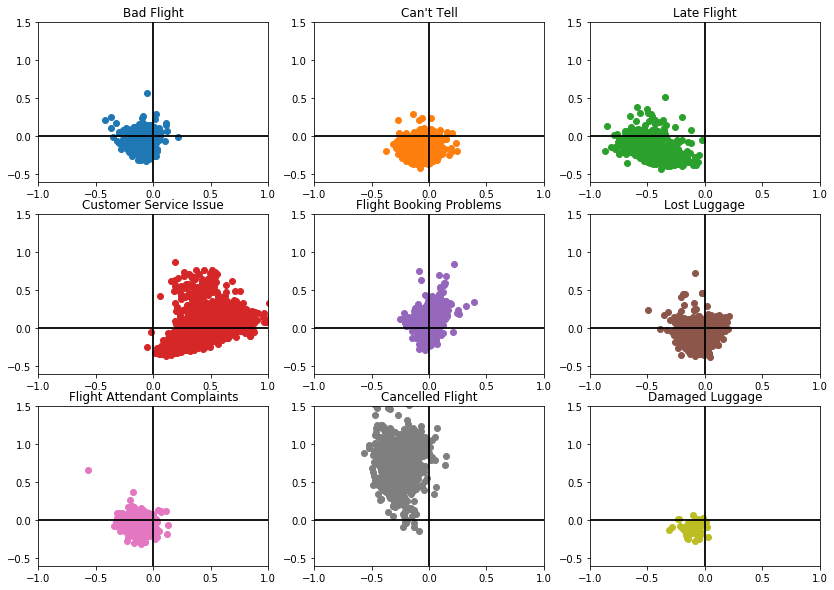

In [45]:
cp = sns.color_palette(n_colors=len(classes))

plt.figure(figsize=(14, 10))
y_train_flat = y_train.argmax(axis=1)
for i, c in enumerate(classes[:-1]):
    plt.subplot(331 + i)
    plt.title(c)
    ind = np.where(y_train_flat == i)[0]
    plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color=cp[i], label=c)
    plt.xlim([-1, 1])
    plt.ylim([-0.6, 1.5])
    plt.axvline(x=0, color="black", linewidth=1.8)
    plt.axhline(y=0, color="black", linewidth=1.8)
plt.show()